<a href="https://colab.research.google.com/github/meghutch/Breast-Cancer-Classification-Clinical-Genomic/blob/master/Neural_Network_Clinical_Outcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Clinical Outcomes of Breast Cancer Patients**

**Author:** Meg Hutch

**Date:** October 31, 2019

**Objective:** Examining the data from Lee's ML course

This project will investigate predicting the survival of patients diagnosed with breast cancer using
the METABRIC (Molecular Taxonomy of Breast Cancer International Consortium) dataset [1, 2].
METABRIC contains clinical and demographic data, DNA sequencing, copy-number, and gene
expression data for over 2000 patients.

**The first part of this analysis will examine whether low dimensional clinical data can be used to predict survivial (binary classification)**

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [11]:
# Connect Colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import Data
bc_data = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Data/data_clinical_patient.csv')

In [0]:
#bc_data.info()

# **Pre-Process Data**




Rows 0-3 contain definitions of data and data types. We can remove these

In [0]:
bc_data = bc_data.iloc[4:]

Convert first row to header name

In [0]:
# Convert first row to header name
bc_data = bc_data.rename(columns=bc_data.iloc[0]).drop(bc_data.index[0])

Convert column names to lowercase

In [0]:
# Convert column names to lowercase
bc_data.columns = map(str.lower, bc_data.columns)

# **Explore Data**

**Total Number of Patients**

In [17]:
print('Total Number of Patients:', len(bc_data.index))

Total Number of Patients: 2509


**Remove any incomplete cases**

In [0]:
bc_data = bc_data.dropna()

**Re-Examine Total Number of Patients**

In [19]:
print('Total Number of Patients after Removing NAs:', len(bc_data.index)) # This removes about 1000 patients from the analysis 

Total Number of Patients after Removing NAs: 1519


**In the project directions, it says we can treat "Died of Other Causes" as living. Thus, change the category title as such.**

In [0]:
bc_data['vital_status'] = bc_data['vital_status'].replace({'Living': 'Living', 'Died of Disease': 'Died of Disease', 'Died of Other Causes': 'Living'})

**Examine Variable Names**

In [21]:
bc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519 entries, 6 to 1985
Data columns (total 21 columns):
patient_id                       1519 non-null object
lymph_nodes_examined_positive    1519 non-null object
npi                              1519 non-null object
cellularity                      1519 non-null object
chemotherapy                     1519 non-null object
cohort                           1519 non-null object
er_ihc                           1519 non-null object
her2_snp6                        1519 non-null object
hormone_therapy                  1519 non-null object
inferred_menopausal_state        1519 non-null object
intclust                         1519 non-null object
age_at_diagnosis                 1519 non-null object
os_months                        1519 non-null object
os_status                        1519 non-null object
claudin_subtype                  1519 non-null object
threegene                        1519 non-null object
vital_status                 

**Examine Variable Distributions**

Text(0.5, 1.0, 'Histological Subtype')

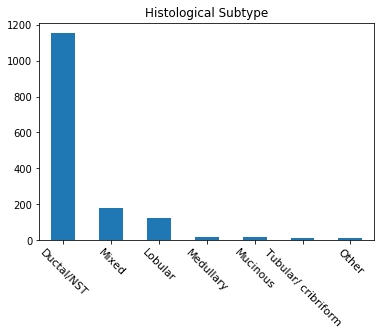

In [22]:
plt1 = bc_data.histological_subtype.value_counts().plot(kind="bar")
plt1.tick_params(axis="x", labelsize=11, labelrotation= -45)
plt1.set_title("Histological Subtype")

Text(0.5, 1.0, 'Survival')

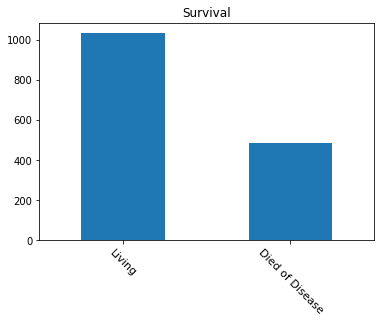

In [23]:
plt2 = bc_data.vital_status.value_counts().plot(kind="bar")
plt2.tick_params(axis="x", labelsize=11, labelrotation= -45)
plt2.set_title("Survival")

Text(0.5, 1.0, 'Three Gene Classifier')

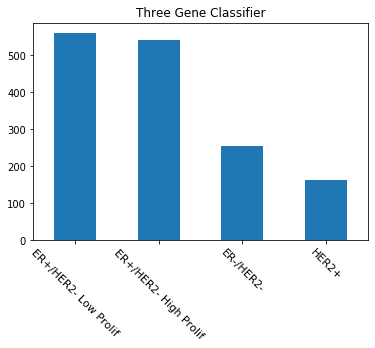

In [24]:
plt3 = bc_data.threegene.value_counts().plot(kind="bar")
plt3.tick_params(axis="x", labelsize=11, labelrotation= -45)
plt3.set_title("Three Gene Classifier")

Text(0.5, 1.0, 'Cellularity')

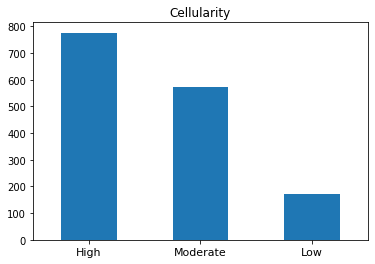

In [25]:
plt4 = bc_data.cellularity.value_counts().plot(kind="bar")
plt4.tick_params(axis="x", labelsize=11, labelrotation= 360)
plt4.set_title("Cellularity")

Text(0.5, 1.0, 'Chemotherapy')

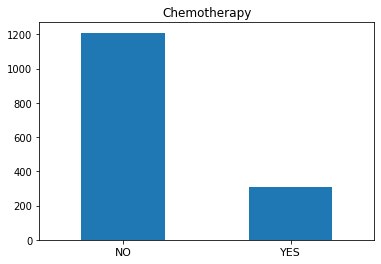

In [26]:
plt5 = bc_data.chemotherapy.value_counts().plot(kind="bar")
plt5.tick_params(axis="x", labelsize=11, labelrotation= 360)
plt5.set_title("Chemotherapy")

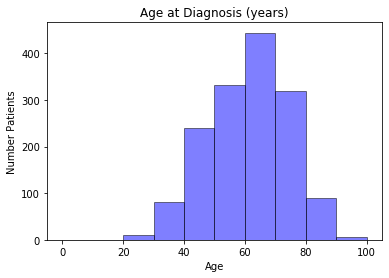

In [27]:
# Convert object to float
age = bc_data['age_at_diagnosis'].astype(float)

# Define bins
bin_edges = [0,10,20,30,40,50,60,70,80,90,100]

plt.hist(age,
         bins=bin_edges,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)

plt.xlabel('Age')
plt.ylabel('Number Patients')
plt.title('Age at Diagnosis (years)')

plt.show()

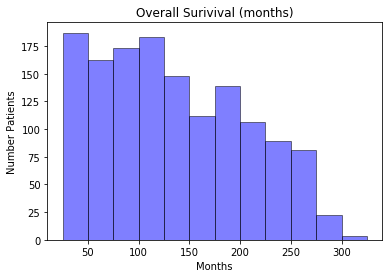

In [28]:
# Convert object to float
os = bc_data['os_months'].astype(float)

# Define bins
bin_edges = [25,50,75,100,125,150,175,200,225,250,275,300,325]

plt.hist(os,
         bin_edges,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)

plt.xlabel('Months')
plt.ylabel('Number Patients')
plt.title('Overall Surivival (months)')

plt.show()

**Examine Patient Outcomes**

vital_status
Died of Disease     485
Living             1034
dtype: int64
Percent Living: 0.7
Percent Died of Disease: 0.3


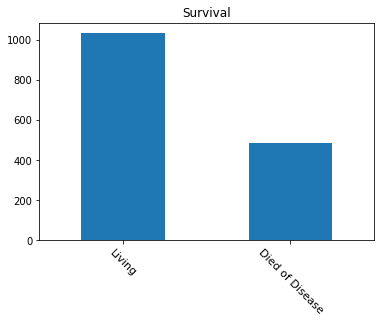

In [29]:
plt_out = bc_data.vital_status.value_counts().plot(kind="bar")
plt_out.tick_params(axis="x", labelsize=11, labelrotation= -45)
plt_out.set_title("Survival")

# Calculate Percents
count_outcomes = bc_data.groupby(['vital_status']).size()
print(count_outcomes)

print('Percent Living: {:.1f}'.format(count_outcomes["Living"]/len(bc_data.index)))
print('Percent Died of Disease: {:.1f}'.format(count_outcomes["Died of Disease"]/len(bc_data.index)))

# **Pre-Process Data**#

Because some categorical features have multiple categories, we need to use one-hot-encoding to represent these varaibles in the dataset. Just creating numeric levels won't always make sense in the case of features like caludin_subtype which are genomic classifications

In [30]:
# Determine which variables we want to one-hot-encode
print('Cellularity:', bc_data['cellularity'].unique())
print('Chemotherapy:',bc_data['chemotherapy'].unique())
print('Er_ihc:',bc_data['er_ihc'].unique())
print('Her2_snp6:',bc_data['her2_snp6'].unique())
print('Hormone Therapy:',bc_data['hormone_therapy'].unique())
print('Inferred_menopausal_state:',bc_data['inferred_menopausal_state'].unique())
print('Interclust:',bc_data['intclust'].unique())
print('Claudin_Subtype:',bc_data['claudin_subtype'].unique())
print('Threegene:',bc_data['threegene'].unique())
print('Laterality:',bc_data['laterality'].unique())
print('Radio_Therapy:',bc_data['radio_therapy'].unique())
print('Histological_Subtype:',bc_data['histological_subtype'].unique())
print('Breast_Surgery:',bc_data['breast_surgery'].unique())
print('Vital_status:',bc_data['vital_status'].unique())

Cellularity: ['High' 'Moderate' 'Low']
Chemotherapy: ['NO' 'YES']
Er_ihc: ['Positve' 'Negative']
Her2_snp6: ['NEUTRAL' 'GAIN' 'LOSS' 'UNDEF']
Hormone Therapy: ['YES' 'NO']
Inferred_menopausal_state: ['Pre' 'Post']
Interclust: ['4ER+' '9' '7' '3' '8' '10' '5' '6' '1' '2' '4ER-']
Claudin_Subtype: ['LumA' 'LumB' 'Her2' 'Normal' 'Basal' 'claudin-low' 'NC']
Threegene: ['ER+/HER2- High Prolif' 'ER+/HER2- Low Prolif' 'ER-/HER2-' 'HER2+']
Laterality: ['Right' 'Left']
Radio_Therapy: ['YES' 'NO']
Histological_Subtype: ['Ductal/NST' 'Mixed' 'Lobular' 'Tubular/ cribriform' 'Mucinous'
 'Medullary' 'Other']
Breast_Surgery: ['BREAST CONSERVING' 'MASTECTOMY']
Vital_status: ['Living' 'Died of Disease']


In [0]:
# Convert patinet_ids to row names first
bc_data = bc_data.set_index(bc_data.patient_id)

In [0]:
# Create dataframe with the unchange varaibles - this will contain numeric variables
bc_data1 = bc_data[['lymph_nodes_examined_positive', 'npi', 'age_at_diagnosis', 'os_months', 'vital_status']]

# Seperate the dataframes into the varaibles that we will want to reshape - we can then recombine after - anything that has more than 2 levels

# Cellularity
cell_df = bc_data[['cellularity']]
cell_df = pd.get_dummies(cell_df,prefix=['cellularity'])

# Chemotherapy
chemo_df = bc_data[['chemotherapy']]
chemo_df = pd.get_dummies(chemo_df,prefix=['chemotherapy'])

# Cohort
cohort_df = bc_data[['cohort']]
cohort_df = pd.get_dummies(cohort_df,prefix=['cohort'])

# er_ihc
er_df = bc_data[['er_ihc']]
er_df = pd.get_dummies(er_df,prefix=['er_ihc'])

# Her2_snp6
her2_df = bc_data[['her2_snp6']]
her2_df = pd.get_dummies(her2_df,prefix=['her2'])

# Hormone Therapy
ht_df = bc_data[['hormone_therapy']]
ht_df = pd.get_dummies(ht_df,prefix=['hormone_therapy'])

# Inferred Menopasual State
ims_df = bc_data[['inferred_menopausal_state']]
ims_df = pd.get_dummies(ims_df,prefix=['ims_df'])

# Interclust
intclust_df = bc_data[['intclust']]
intclust_df = pd.get_dummies(intclust_df,prefix=['intclust'])

# Claduin Subtype
cs_df = bc_data[['claudin_subtype']]
cs_df = pd.get_dummies(cs_df,prefix=['claudin_subtype'])

# Threegene
three_df = bc_data[['threegene']]
three_df = pd.get_dummies(three_df,prefix=['threegene'])

# Laterality
lat_df = bc_data[['laterality']]
lat_df = pd.get_dummies(lat_df,prefix=['laterality'])

# Radiotherapy
rt_df = bc_data[['radio_therapy']]
rt_df = pd.get_dummies(rt_df,prefix=['radio_therapy'])

# Histological_Subtype
hist_df = bc_data[['histological_subtype']]
hist_df = pd.get_dummies(hist_df,prefix=['hist'])

# Breast Surgery
surg_df = bc_data[['breast_surgery']]
surg_df = pd.get_dummies(surg_df,prefix=['breast_surgery'])

# Combine dataframes
bc_data2 = cell_df.reset_index(drop=True).merge(her2_df.reset_index(drop=True), left_index=True, right_index=True)
bc_data2 = bc_data2.reset_index(drop=True).merge(intclust_df.reset_index(drop=True), left_index=True, right_index=True)
bc_data2 = bc_data2.reset_index(drop=True).merge(cs_df.reset_index(drop=True), left_index=True, right_index=True)
bc_data2 = bc_data2.reset_index(drop=True).merge(three_df.reset_index(drop=True), left_index=True, right_index=True)
bc_data2 = bc_data2.reset_index(drop=True).merge(hist_df.reset_index(drop=True), left_index=True, right_index=True)

# Merge all data 
bc_data = bc_data2.reset_index(drop=True).merge(bc_data1.reset_index(drop=True), left_index=True, right_index=True)

In [0]:
#bc_data

Create dummy variables for Vital Status - Our Label

In [0]:
bc_data['vital_status'] = bc_data.vital_status.map({'Living': 0, 'Died of Disease': 1})

Covert numeric varaibles as such, right now they are all non-null objects

In [0]:
bc_data = bc_data.astype(np.float32)

In [36]:
bc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 41 columns):
cellularity_High                   1519 non-null float32
cellularity_Low                    1519 non-null float32
cellularity_Moderate               1519 non-null float32
her2_GAIN                          1519 non-null float32
her2_LOSS                          1519 non-null float32
her2_NEUTRAL                       1519 non-null float32
her2_UNDEF                         1519 non-null float32
intclust_1                         1519 non-null float32
intclust_10                        1519 non-null float32
intclust_2                         1519 non-null float32
intclust_3                         1519 non-null float32
intclust_4ER+                      1519 non-null float32
intclust_4ER-                      1519 non-null float32
intclust_5                         1519 non-null float32
intclust_6                         1519 non-null float32
intclust_7                         151

# **Predicting Clinical Outcomes**

We will attempt to predict vital status using:

* Logistic Regression
* Random Forest
* Neural Networks. 

Logistic regression and random forst classiers can help serve as a benchmark of performance once we develop our neural network classifier.

# **Training and Testing Split**

For all of our classification methods, we will create a training and a testing set.

In [0]:
# Packagess
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Format the bc_data into a features and label dataframe

In [0]:
# Let x represent the input features; y the labels

# Want to remove os_months, os_status, and vital_status from inputs since these are what we are trying to predict. We will include vital status as our label. I already remove os_status by leaving it out of pre-processing above, since I felt this was similar to vital_status

# create x to represent the input features; y is the label; 
x =  bc_data.drop(['os_months', 'vital_status'], axis=1)
y =  bc_data.vital_status

Split the data into testing and training sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=25)

View the shapes of the training and testing sets; the datasets ending in "train" are our training sets; similarly, those ending in "test" are the testing; x prefix always represents the input features, y the labels

In [40]:
# Assess the trainig and testing sets previously created
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1139, 39)
Training Labels Shape: (1139,)
Testing Features Shape: (380, 39)
Testing Labels Shape: (380,)


Examine the class distributions - these are similar splits between the training and testing sets. This is also representative of the number of cases throughout the entire dataset.

In [41]:
# Malignant = 1; Count the number of malignant and determine the percentage (traning has 426 values, testing has 143)
print('Died of Diseases in Training Set:', np.count_nonzero(y_train == 1))
print('Died of Diseases in Testing Set:', np.count_nonzero(y_test == 1))

# Percents
print('% Died of Diseases Cases in Training Set:', round(np.count_nonzero(y_train == 1)/1139*100,2))
print('% Died of Diseases Cases in Testing Set:', round(np.count_nonzero(y_test == 1)/380*100,2))

Died of Diseases in Training Set: 373
Died of Diseases in Testing Set: 112
% Died of Diseases Cases in Training Set: 32.75
% Died of Diseases Cases in Testing Set: 29.47


# **Logistic Regression**

These steps were followed from the following tutorial:

https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

**Define and Run the Model**

In [42]:
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Model Evaluation Using Confusion Matrix**

In [43]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[239,  29],
       [ 79,  33]])

The confusion matrix generated above is in the form of an array. Diagnosal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. The diagonal starting with the top left to the bottom right hand corner are actual predidictions, while the bottom left corner to the top right corner are incorrect predictions. 

In [44]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))

Accuracy: 0.716
Precision: 0.532
Recall: 0.295


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 

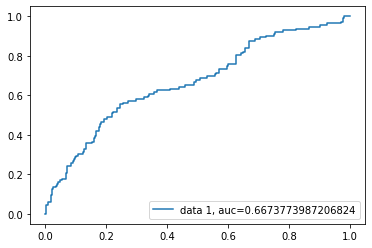

AUC: 0.667


In [45]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

# **Random Forest Classification**

I followed the tutorial here:  https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 and https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

**Train the Model**

In [52]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel # to identify features

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=45, verbose=0,
                       warm_start=False)

**Select Important Features**

In [58]:
# First feature selection test
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat)) # 3 or 4 features selected as important depending on each run; often is "cellularity_High", "lymph_nodes_examined_positive", "npi"
selected_feat

4


Index(['cellularity_High', 'lymph_nodes_examined_positive', 'npi',
       'age_at_diagnosis'],
      dtype='object')

**Make Predictions on the Test Set**

In [0]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Probabilities for each class
rf_probs = rf.predict_proba(X_test)[:, 1]

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

**Evaluating the Performance**

For Classification Problems the metrics used to evaluate an algorithm are accuracy, confusion matrix, precision, recall, and F1 values.

We can also perform cross-fold validation to have a better understanding of the results

Reference: #https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652 

**ROC on the Full Data**


We make class predictions (predict) as well as predicted probabilities (predict_proba) to calculate the ROC AUC. Once we have the testing predictions, we can calculate the ROC AUC. https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [0]:
from sklearn.metrics import roc_auc_score

# Calculate ROC AUC
roc_value = roc_auc_score(y_test, rf_probs) 

roc_value

In [0]:
# Probabilities for each class
# Note from scikit learn: re fpr and tpr: "Since the thresholds are sorted from low to high values, they are reversed upon returning them to ensure they correspond to both fpr and tpr, which are sorted in reversed order during their calculation."
rf_probs = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_probs)
auc = metrics.roc_auc_score(y_test, rf_probs)
auc = round(auc, 4)
plt.plot(fpr, tpr, label="date 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**10 Cross-Fold Validation**

In [0]:
rfc_cv_score = cross_val_score(rf, x, y, cv=10, scoring='roc_auc') 

Below, we also can examine the confusion matrix, the classification report containing precision, recall, f1-score, and support, All AUC scores, and the mean AUC score

The **confusion matrix** is useful for giving false positives and false negatives

The **ROC Curve** plots out the true positive rate vs the false positive rate at various thresholds

The **ROC AUC Scoring** used in the cross-validation model shows the area under the ROC curve

In [0]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
print('\n')
print("=== Accuracy Score ===")
print("Accuracy:", accuracy_score(y_test, predictions))

# **Logistic Regression and Random Forest Results**

**Logistic Regression classifier:**

* AUC: 0.667
* Accuracy: 0.716
* Precision: 0.532
* Recall: 0.295


**Random Forest classifier:**

* AUC: 0.62
* AUC Mean 10 Fold Validation: 0.64
* Accuracy 10 Fold Validation: 0.689

# **PyTorch Neural Network For Classification**

We will evaluate the use of a neural network classifier on the testing data as developed above and compare the outputs to the logistic regression and random forest classifiers above. 

In [0]:
# Import PyTorch packages
import torch
from torch import nn
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

**Format the Training Dataset**

In [0]:
# Convert data into arrays
xb = np.array(X_train, dtype = "float32")
yb = np.array(y_train, dtype = "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

# Combine the arrays
trainloader = TensorDataset(xb, yb)

# Define the batchsize
batch_size = 32

# Training Loader
trainloader = DataLoader(trainloader, batch_size, shuffle=True)

**Format the Testing Dataset**

In [0]:
# Convert data into arrays
xb = np.array(X_test, dtype = "float32")
yb = np.array(y_test, dtype = "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

# Combine the arrays
testloader = TensorDataset(xb, yb) 

# Define the batchsize
batch_size= 32

# Training Loader
testloader = DataLoader(testloader, batch_size, shuffle=True) 

**Create Neural Network Model**

In [0]:
# Define the model with hidden layers - 39 inputs
model = nn.Sequential(nn.Linear(39, 20),
                      nn.ReLU(),
                      nn.Linear(20, 10),
                      nn.ReLU(),
                      nn.Linear(10, 1), 
                      nn.Sigmoid())
                      
# Set optimizer and learning rate
#optimizer = optim.SGD(model.parameters(), lr=0.003)

# Could also use Adam optimizer; similar to stochastic gradient descent, but uses momentum which can speed up the actual fitting process, and it also adjusts the learning rate for each of the individual parameters in the model
optimizer = optim.Adam(model.parameters(), lr=0.04)

criterion = nn.BCELoss() # use with a sigmoid function

#criterion = nn.CrossEntropyLoss() #don't use with softmax or sigmoid

# Set epochs
epochs = 100
for e in range(epochs):
    running_loss = 0
    for xb, yb in trainloader:
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        # Training pass
        output = model.forward(xb)
        loss = criterion(output, yb) # Loss calculated from the output compared to the labels  
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # loss.item() gets the scalar value held in the loss. Running_loss = 0, 
        # += notation, says "Add a value and the variable and assigns the result to that variable." So, adds the running_loss (0) with loss.item and assigns to running_loss
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

**Evaluate Model Performance**

In [0]:
# Convert data into arrays
xb = np.array(X_test, dtype = "float32")
yb = np.array(y_test, dtype = "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

# Apply the model to the whole testing dataset
ps = model(xb)

#print('Probabilities', ps[:10])

# Obtain the top probability
top_p, top_class = ps.topk(1, dim=1)
#print('true vals', yb[:10])

# Drop the grad 
top_p = top_p.detach().numpy()
top_class = top_class.detach().numpy()

top_class = (top_p >= 0.5).astype(np.int)
#print('top class', top_class[:10])

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(yb, top_p, pos_label=1)

# Compute ROC area
roc_auc = round(auc(fpr, tpr),3)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Classification Report
print("=== Confusion Matrix ===")
print(confusion_matrix(yb, top_class))
print('\n')
print("=== Classification Report ===")
print(classification_report(yb, top_class))
print('\n')
print("=== Accuracy Score ===")
print("Accuracy:", round(accuracy_score(yb, top_class),3))

**November 15th Notes:**

*Question: BCEWithLogitLoss vs BCELoss for binary classification? Some sources seem to suggest that BCEWithLogitLoss is more numerically stable, but I'm unclear if this is just for multi-class classification? https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/15

# **Experiements**

**November 15th - Neural Network Architecture:**

**Loss:** Binary Cross Entropy Loss

**Activation:** ReLU

**Batchsize:** 32


1) Hidden Layers (30, 20), epochs = 200, SGD, LR = 0.01

* AUC = 0.651
* Accuracy= 70%

                  === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81       268
         1.0       0.48      0.24      0.32       112
      accuracy                         0.70       380
      macro avg    0.61      0.57      0.56       380
      weighted avg 0.66      0.70      0.66       380

2) Hidden Layers (30, 20), **epochs = 100**, SGD, LR = 0.01

* AUC = 0.643
* Accuracy= 70.5%

                  === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.73      0.92      0.82       268
         1.0       0.50      0.19      0.27       112
      accuracy                         0.71       380
      macro avg    0.62      0.55      0.54       380
      weighted avg 0.66      0.71      0.66       380

3) Hidden Layers (30, 20), epochs = 100, SGD, **LR = 0.009**

* AUC = 0.645
* Accuracy= 70.5%

4) Hidden Layers (30, 20), epochs = 100, SGD, **LR = 0.005**

* AUC = 0.650
* Accuracy= 70.3%

5) Hidden Layers (30, 20), epochs = 100, SGD, **LR = 0.003**

* **AUC = 0.656**
* Accuracy= 70.5%

                    === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.74      0.89      0.81       268
         1.0       0.50      0.26      0.34       112
      accuracy                         0.71       380
      macro avg    0.62      0.58      0.58       380
      weighted avg 0.67      0.71      0.67       380

6) Hidden Layers (30, 20), epochs = 100, SGD, **LR = 0.001**

* AUC = 0.626
* **Accuracy= 71.8%**

                    === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83       268
         1.0       0.59      0.14      0.23       112
        accuracy                       0.72       380
        macro avg  0.66      0.55      0.53       380
      weighted avg 0.69      0.72      0.65       380
Accuracy increased probably due to the high specificity, but AUC decreased, poor recall! I will go back to a learning rate of 0.003 for now.  

7) Hidden Layers (30, 20), **epochs = 150**, SGD, LR = 0.003

* AUC = 0.651
* Accuracy= 70.5%

Similar performance to expereiment #5, thus, I will lower epochs to 80. 

8) Hidden Layers (30, 20), **epochs = 80**, SGD, LR = 0.003

* AUC = 0.626
* Accuracy= 69.7

9) Hidden Layers (30, 20), **epochs = 120**, SGD, LR = 0.003

* AUC = 0.647 
* Accuracy= 69.7%

10) Hidden Layers (30, 20), **epochs = 100**, **Adam**, **LR = 0.03**

* **AUC = 0.669**
* Accuracy = 0.692

                    === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80       268
         1.0       0.46      0.29      0.36       112
       accuracy                        0.69       380
      macro avg    0.60      0.58      0.58       380
      weighted avg 0.66      0.69      0.67       380

11) Hidden Layers (30, 20), epochs = 100, Adam, **LR = 0.01**

* **AUC = 0.668**
* Accuracy = 0.705

                      === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81       268
         1.0       0.50      0.29      0.37       112
        accuracy                       0.71       380
        macro avg  0.62      0.59      0.59       380
      weighted avg 0.68      0.71      0.68       380

12) Hidden Layers (30, 20), epochs = 100, Adam, **LR = 0.008**

* led to slight declines in performance compared to prior Adam models

13) Hidden Layers (30, 20), epochs = 100, Adam, **LR = 0.05**

* Also led to slight declines in performance compared to prior Adam models




# **Results**

November 15: Form the first round of experiments, the highest performing model was the following: 

**Loss:** Binary Cross Entropy Loss

**Activation:** ReLU

**Batchsize:** 32

**Hidden Layers:** (30, 20)

**epochs:** 100

**Optimizer:** Adam

**Learning Rate:** 0.03


**Performance:**

**AUC** = 0.669

                    === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80       268
         1.0       0.46      0.29      0.36       112
       accuracy                        0.69       380
      macro avg    0.60      0.58      0.58       380
      weighted avg 0.66      0.69      0.67       380


# **Experiments: Changing Hidden Layer Nodes**

November 15th - Neural Network Architecture:

Loss = Binary Cross Entropy Loss Activation = ReLU Batchsize = 32

1) Hidden Layers (20, 10), epochs = 100, Adam, LR = 0.03

**AUC**: 0.644

                    === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       268
         1.0       0.47      0.38      0.42       112
      accuracy                         0.69       380
      macro avg    0.62      0.60      0.60       380
      weighted avg 0.67      0.69      0.68       380

2) Hidden Layers (20, 10), epochs = 100, Adam, **LR = 0.04**

**AUC**: 0.661

                  === Classification Report ===
              precision    recall  f1-score   support
         0.0       0.75      0.86      0.80       268
         1.0       0.49      0.32      0.39       112
      accuracy                         0.70       380
      macro avg    0.62      0.59      0.60       380
      weighted avg 0.68      0.70      0.68       380

The F1 score is much improved from the past experiments. I will continue to experiement here

3) I decreased epochs to 80 and increased to 120 and 150 and this decreased performance. 

A few runs of Experiement #1 and #2 actaully gave AUCs of ~0.70

4) Hidden Layers (20, 10), epochs = 100, Adam, **LR = 0.04** - re ran again

**AUC:** 0.674

                    === Classification Report ===
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78       268
         1.0       0.48      0.52      0.50       112
      accuracy                         0.69       380
      macro avg    0.64      0.64      0.64       380
    weighted avg   0.70      0.69      0.70       380

**F1** for patients who died of disase is much higher than in previous models. 

5) I tried different architectures without much difference in regards to model improvement


# **Final Results**

**November 15, 2019:** 

Best Performing model had the following characteristics: 

**Loss:** Binary Cross Entropy Loss

**Activation:** ReLU

**Batchsize:** 32

**Hidden Layers:** (20, 10)

**epochs:** 100

**Optimizer:** Adam

**Learning Rate:** 0.03

**Model Performance:**

**AUC: 0.674**

**F1: 0.52** 

**Accuracy: 0.69%**

# **Next Steps/Follow-up Question**

1.   Ensure that Binary Cross Entropy is an okay loss function
2.   Recall tends to be worse than specificty, okay for now? Maybe this is due to the class imbalance? Could try incoporating this into the loss function or resampling methods?
3.   Could attempt to perform cross-fold validaiton like I did with random forests classification. 

